In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [3]:
import os
import pickle as pkl
from TileEM_plot_toolbox import *
# DATA_DIR="final_all_tiles"
# os.chdir(DATA_DIR)

In [38]:
def colorbar_index(ncolors, cmap):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in xrange(N+1) ]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

def visualizeTilesScore(tiles,tidx_score,INT_Z=True,colorful=True):
    '''
    Given a dictionary consisting of {tidx:score} 
    Plot a heatmap of values
    INT_Z: integet z value colormap
    '''
    plt.figure()
    #colors=cm.rainbow(np.linspace(0,1,len(set(tidx_score.values()))+1))

    score = tidx_score.values()
    norm = matplotlib.colors.Normalize(
        vmin=np.min(score),
        vmax=np.max(score))
    c_m = cm.rainbow

    s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
    s_m.set_array([])

    for tidx,i in tidx_score.iteritems(): 
        t=tiles[tidx]
        if colorful: 
            c=s_m.to_rgba(i)
        else: 
            c="lime"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True,fill_color=c)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True,fill_color=c)

    if INT_Z:
        colorbar_index(ncolors=len(set(score)), cmap=c_m)
    else:
        plt.colorbar(s_m)
    #xylocs of the largest tile for estimating the obj size
    xlocs,ylocs = tiles[argmax([t.area for t in tiles])].exterior.coords.xy
    plt.ylim(min(ylocs)-50,max(ylocs)+50)
    plt.gca().invert_yaxis()
def adjacent(tileA,tileB):
    return tileA.buffer(0.1).overlaps(tileB.buffer(0.1))
def compute_adjacency_score(objid,CHECK=True,SAVE=True):
    tiles = pkl.load(open("vtiles{}.pkl".format(objid),'r'))
    if CHECK: print "Joining tiles "
    tile_area = [t.area for t in tiles]
    top_5percent_largest = np.where(tile_area>np.percentile(tile_area,98))[0]
    jtiles,ptiles = join_tiles(top_5percent_largest,tiles)
    if CHECK: 
        visualizeTilesSeparate(tiles)
        plt.title("Obj{}: Check Centroid inside central tile ".format(objid))
        plt.plot(jtiles.centroid.x,jtiles.centroid.y,'o')
        
    if CHECK: print 'Find the tile index of the tile that contains the centroid'
    central_tidx =  -1
    for i,t in enumerate(tiles):
        if t.contains(jtiles.centroid):
            central_tidx =  i
            break
    if CHECK: 
        plt.figure()
        plt.title("Shape of Central Tile")
        plot_coords(tiles[central_tidx],reverse_xy=True)
        
    tiles_adjacency ={}
    tiles_adjacency[central_tidx]=0
    leftovers=range(len(tiles))
    prev_tiles = [central_tidx]
    d=1
    while (len(leftovers)!=0):
        # prev_tiles = tiles that are at d-1 distance away 
        #d = 1 # Find all tiles that are d distance away 
    # for i,t in enumerate(tiles):
        #used_tiles_iter=copy.deepcopy(used_tiles_adjacency)
        print "d= {} iteration".format(d)
        print "Leftovers after:",len(leftovers)
        next_tiles=[]
        for utidx in prev_tiles:
            ut = tiles[utidx]
            for tidx in leftovers:
                t = tiles[tidx]
                if adjacent(t,ut):
                    #print utidx,tidx
                    tiles_adjacency[tidx]=d
                    next_tiles.append(tidx)
        prev_tiles=next_tiles
        #print "Leftovers before:",len(leftovers)
        leftovers = [tidx for tidx in leftovers if tidx not in  tiles_adjacency.keys()]
        d+=1
    if CHECK: 
        visualizeTilesScore(tiles,tiles_adjacency)
        plt.title("Tile Adjacency Score Heatmap ")
    if SAVE: pkl.dump(tiles_adjacency,open("adjacency{}.pkl".format(objid),'w'))
    return tiles_adjacency

If we just join together the top 5% of the tiles, we could probably recreate the bounding box for the purpose of finding a centroid 

In [21]:
tile_area = [t.area for t in tiles]
top_5percent_largest = np.where(tile_area>np.percentile(tile_area,98))[0]
jtiles,ptiles = join_tiles(top_5percent_largest,tiles)

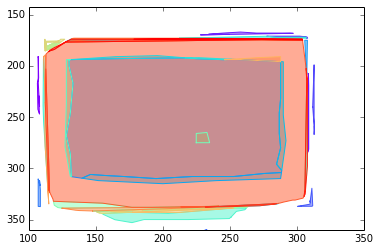

In [34]:
visualizeTilesSeparate(np.array(tiles)[top_5percent_largest])

In [35]:
ptiles

[]

In [36]:
jtiles.centroid.x

209.7460778489634

In [37]:
jtiles.centroid.y

257.99877549401765

In [29]:
jtiles.centroid.x

206.88692393790728

In [30]:
jtiles.centroid.y

257.0751169605438

In [5]:
# cd ../final_all_tiles/

In [13]:
cd ..

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [14]:
DATA_DIR="final_all_tiles"
# DATA_DIR="sampletopworst5"
os.chdir(DATA_DIR)

In [15]:
objid=18
tiles = pkl.load(open("vtiles{}.pkl".format(objid)))

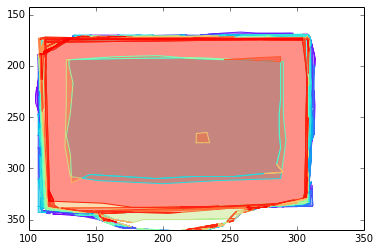

In [19]:
visualizeTilesSeparate(tiles)

Joining tiles 
Find the tile index of the tile that contains the centroid
d= 1 iteration
Leftovers after: 13
d= 2 iteration
Leftovers after: 4


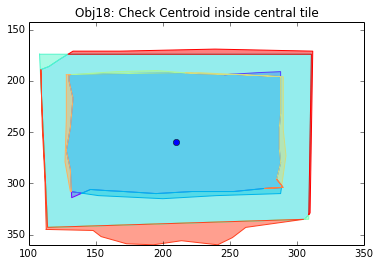

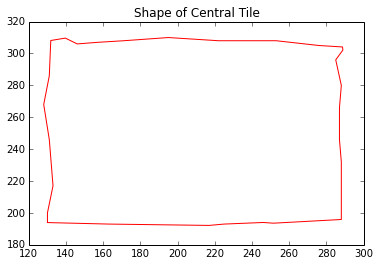

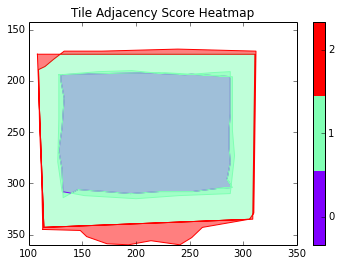

In [10]:
tiles_adjacency = compute_adjacency_score(18)

In [39]:
cd ../final_all_tiles/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [ ]:
tiles_adjacency = compute_adjacency_score(18)

In [6]:
# selected_objids=[ 5,  6,  8,  9, 14, 15, 18, 19, 20, 21, 23, 24, 25, 27, 29, 30,33, 35, 37, 46]
# for objid in tqdm(selected_objids):
#     tiles_adjacency = compute_adjacency_score(objid)